<a href="https://colab.research.google.com/github/Angryraj/dynamic-traffic-signal/blob/main/finalsih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


0: 640x384 14 cars, 2 trucks, 381.2ms
Speed: 6.3ms preprocess, 381.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)

0: 480x640 5 persons, 13 cars, 4 motorcycles, 473.4ms
Speed: 5.7ms preprocess, 473.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)
Error opening video stream or file: 
Error opening video stream or file: 
Lane 1 - Vehicles: 16, Emergency Vehicles: 10, FASTag: 75, Avg Distance: 32.63 meters, Signal Timing Adjustment: 55.78 seconds
Lane 2 - Vehicles: 22, Emergency Vehicles: 4, FASTag: 99, Avg Distance: 20.53 meters, Signal Timing Adjustment: 57.93 seconds
Lane 3 - Vehicles: 0, Emergency Vehicles: 2, FASTag: 80, Avg Distance: 0.00 meters, Signal Timing Adjustment: 45.13 seconds
Lane 4 - Vehicles: 0, Emergency Vehicles: 5, FASTag: 90, Avg Distance: 0.00 meters, Signal Timing Adjustment: 47.01 seconds
Error loading image: /content/annotated_lane3.jpg
Error loading image: /content/annotated_lane4.jpg


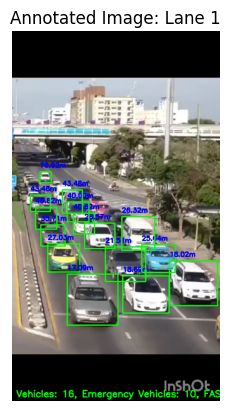

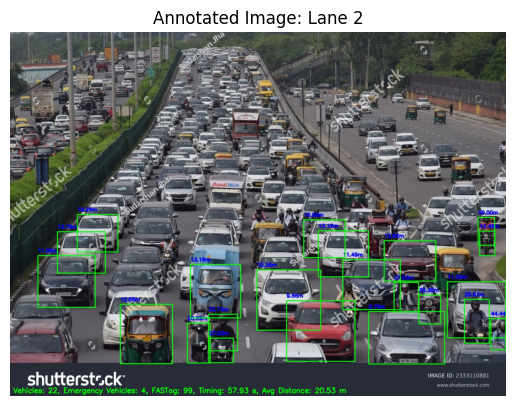

In [7]:
import cv2
import numpy as np
from ultralytics import YOLO
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model = YOLO('yolov8s.pt')  # Ensure this model is appropriate for your needs

# generate random vechile count
def get_random_emergency_vehicle_count():
    return np.random.randint(0, 11)

# generate random fastag count
def get_random_fastag_count():
    return np.random.randint(0, 101)

# calculate traffic density, number of vehicles (save annotated frame)
def calculate_and_save_traffic_density(video_path, output_path, focal_length, object_width):
    total_occupied_area = 0
    vehicle_count = 0
    distances = []
    emergency_vehicle_count = get_random_emergency_vehicle_count()  # Generate random emergency vehicle count

    # video file/camera
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video stream or file: {video_path}")
        return None, 0, [], 0

    # Read a single frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        cap.release()
        return None, 0, [], 0

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    total_road_area = frame_width * frame_height  # Approximate total road area in pixels

    # Run YOLOv8 on the frame
    results = model(frame)

    # Process detected objects
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()  # Get class IDs

        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = box.astype(int)
            vehicle_area = (x2 - x1) * (y2 - y1)
            total_occupied_area += vehicle_area
            vehicle_count += 1

            # predicting distance of the vehicle from the camera
            vehicle_pixel_width = x2 - x1
            if vehicle_pixel_width > 0:
                distance = (focal_length * object_width) / vehicle_pixel_width
                distances.append(distance)
            else:
                distances.append(0)

            # Draw bounding boxes and distance on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{distance:.2f}m", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Save the annotated frame
    cv2.imwrite(output_path, frame)

    # Release video capture object
    cap.release()

    #traffic density calculation
    traffic_density = total_occupied_area / total_road_area
    return traffic_density, vehicle_count, distances, emergency_vehicle_count

# Function to simulate FASTag count retrieval
def get_fastag_count(lane_id):
    # Placeholder function - Replace with actual FASTag data retrieval
    # For simulation, generate a random count between 0 and 100
    return np.random.randint(0, 101)

# Paths to the video files and output paths for the four lanes
video_paths = ['', '', '', '']
output_paths = ['/content/annotated_lane1.jpg', '/content/annotated_lane2.jpg', '/content/annotated_lane3.jpg', '/content/annotated_lane4.jpg']

# Define the focal length and object width for distance calculation
focal_length = 1000  # Calibrate this for your camera
object_width = 2  # Width of a car in meters

# Calculate traffic densities, vehicle counts, distances, emergency vehicle counts, and save annotated frames for each lane
traffic_densities = []
vehicle_counts = []
distances_list = []
emergency_vehicle_counts = []
fastag_counts = []

for lane_id, (video_path, output_path) in enumerate(zip(video_paths, output_paths)):
    density, count, distances, emergency_count = calculate_and_save_traffic_density(video_path, output_path, focal_length, object_width)
    if density is not None:
        traffic_densities.append(density)
        vehicle_counts.append(count)
        distances_list.append(distances)
        emergency_vehicle_counts.append(emergency_count)
        fastag_counts.append(get_fastag_count(lane_id))
    else:
        traffic_densities.append(0)  # Assign 0 if there was an error
        vehicle_counts.append(0)  # Keep actual vehicle count 0
        distances_list.append([])
        emergency_vehicle_counts.append(get_random_emergency_vehicle_count())  # Generate random emergency vehicle count
        fastag_counts.append(get_random_fastag_count())  # Generate random FASTag count

# Define fuzzy variables
traffic_density_var = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'traffic_density')
emergency_vehicle_var = ctrl.Antecedent(np.arange(0, 11, 1), 'emergency_vehicle_count')  # Adjust range as needed
fastag_var = ctrl.Antecedent(np.arange(0, 101, 1), 'fastag_count')  # Assuming count between 0 and 100
signal_timing_adjustment = ctrl.Consequent(np.arange(15, 76, 1), 'signal_timing_adjustment')  # Updated range from 15 to 75 seconds

# Define fuzzy membership functions
traffic_density_var['low'] = fuzz.trimf(traffic_density_var.universe, [0, 0, 0.3])
traffic_density_var['medium'] = fuzz.trimf(traffic_density_var.universe, [0.2, 0.5, 0.8])
traffic_density_var['high'] = fuzz.trimf(traffic_density_var.universe, [0.7, 1.0, 1.0])

emergency_vehicle_var['none'] = fuzz.trimf(emergency_vehicle_var.universe, [0, 0, 1])
emergency_vehicle_var['few'] = fuzz.trimf(emergency_vehicle_var.universe, [0, 2, 5])
emergency_vehicle_var['many'] = fuzz.trimf(emergency_vehicle_var.universe, [4, 10, 10])

fastag_var['low'] = fuzz.trimf(fastag_var.universe, [0, 0, 50])
fastag_var['medium'] = fuzz.trimf(fastag_var.universe, [30, 50, 70])
fastag_var['high'] = fuzz.trimf(fastag_var.universe, [50, 100, 100])

signal_timing_adjustment['short'] = fuzz.trimf(signal_timing_adjustment.universe, [15, 15, 30])
signal_timing_adjustment['medium'] = fuzz.trimf(signal_timing_adjustment.universe, [25, 45, 65])
signal_timing_adjustment['long'] = fuzz.trimf(signal_timing_adjustment.universe, [55, 75, 75])

# Define fuzzy rules with priority for emergency vehicles and FASTag counts
rule1 = ctrl.Rule(traffic_density_var['high'] & emergency_vehicle_var['many'] & fastag_var['high'], signal_timing_adjustment['long'])
rule2 = ctrl.Rule(traffic_density_var['medium'] & emergency_vehicle_var['few'] & fastag_var['medium'], signal_timing_adjustment['medium'])
rule3 = ctrl.Rule(traffic_density_var['low'] & emergency_vehicle_var['none'] & fastag_var['low'], signal_timing_adjustment['short'])
rule4 = ctrl.Rule(emergency_vehicle_var['many'], signal_timing_adjustment['long'])  # Priority for emergency vehicles
rule5 = ctrl.Rule(fastag_var['high'], signal_timing_adjustment['long'])  # Priority for lanes with high FASTag count

# Default rule to handle any other cases
rule6 = ctrl.Rule(traffic_density_var['low'] | emergency_vehicle_var['none'] | fastag_var['low'], signal_timing_adjustment['short'])

# Create a control system and simulation
signal_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
signal_sim = ctrl.ControlSystemSimulation(signal_ctrl)

# Calculate signal timing adjustments for each lane
signal_timings = []
for density, emergency_count, fastag_count in zip(traffic_densities, emergency_vehicle_counts, fastag_counts):
    signal_sim.input['traffic_density'] = density
    signal_sim.input['emergency_vehicle_count'] = emergency_count
    signal_sim.input['fastag_count'] = fastag_count
    signal_sim.compute()
    signal_timing = signal_sim.output['signal_timing_adjustment']
    signal_timings.append(signal_timing)

# Print the signal timing adjustments for all lanes
for i, (timing, count, distances, emergency_count, fastag_count) in enumerate(zip(signal_timings, vehicle_counts, distances_list, emergency_vehicle_counts, fastag_counts), start=1):
    avg_distance = np.mean(distances) if distances else 0
    print(f"Lane {i} - Vehicles: {count}, Emergency Vehicles: {emergency_count}, FASTag: {fastag_count}, Avg Distance: {avg_distance:.2f} meters, Signal Timing Adjustment: {timing:.2f} seconds")

# Display saved annotated  with vehicle count, timing, distance, and emergency vehicle count
for i, (output_path, count, timing, distances, emergency_count, fastag_count) in enumerate(zip(output_paths, vehicle_counts, signal_timings, distances_list, emergency_vehicle_counts, fastag_counts), start=1):
    img = cv2.imread(output_path)
    if img is not None:
        # Add text overlay
        avg_distance = np.mean(distances) if distances else 0
        text = f"Vehicles: {count}, Emergency Vehicles: {emergency_count}, FASTag: {fastag_count}, Timing: {timing:.2f} s, Avg Distance: {avg_distance:.2f} m"
        cv2.putText(img, text, (10, img.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        plt.figure()
        plt.title(f"Annotated Image: Lane {i}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    else:
        print(f"Error loading image: {output_path}")

plt.show()


In [4]:
!pip install ultralytics
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.3 MB/s eta 0:00:00


100%|██████████| 49.7M/49.7M [00:00<00:00, 177MB/s]



0: 384x640 20 cars, 1596.5ms
Speed: 7.4ms preprocess, 1596.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 13 cars, 5 trucks, 1019.2ms
Speed: 5.8ms preprocess, 1019.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 1 car, 1005.5ms
Speed: 4.8ms preprocess, 1005.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 25 cars, 2 trucks, 962.3ms
Speed: 5.5ms preprocess, 962.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


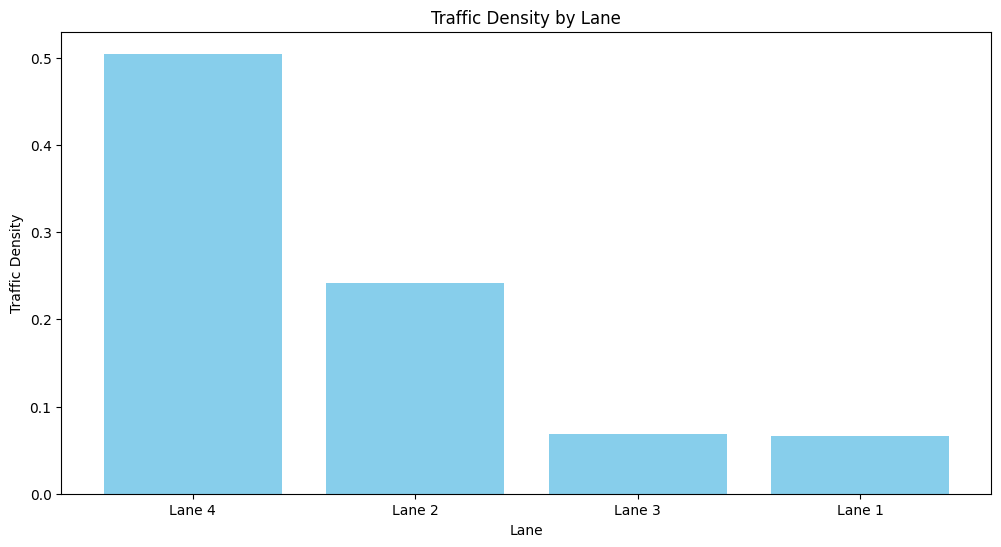

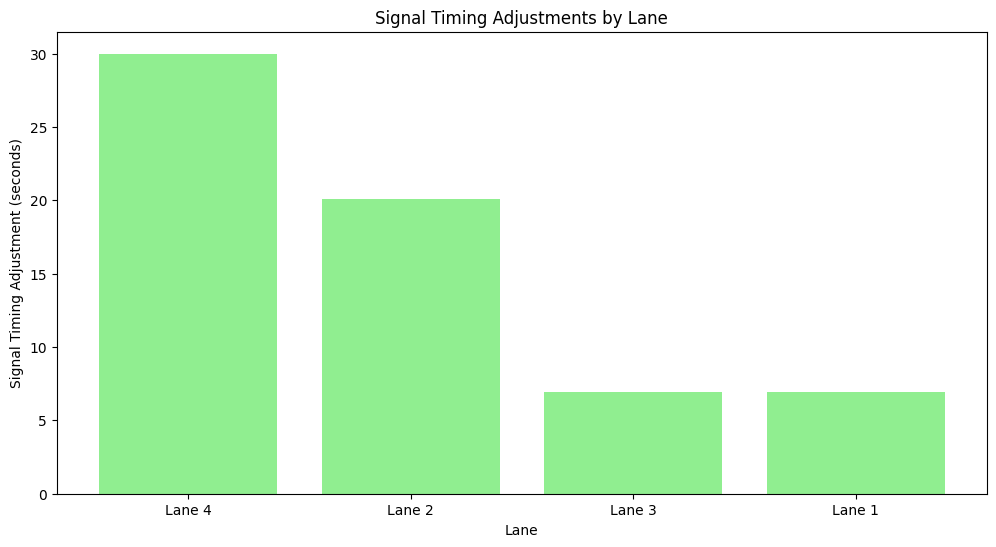

Lane 1 - Vehicles: 20, Avg Distance: 41.48 meters, Signal Timing Adjustment: 6.94 seconds
Lane 2 - Vehicles: 18, Avg Distance: 31.48 meters, Signal Timing Adjustment: 20.09 seconds
Lane 3 - Vehicles: 1, Avg Distance: 4.23 meters, Signal Timing Adjustment: 6.95 seconds
Lane 4 - Vehicles: 27, Avg Distance: 33.30 meters, Signal Timing Adjustment: 30.00 seconds


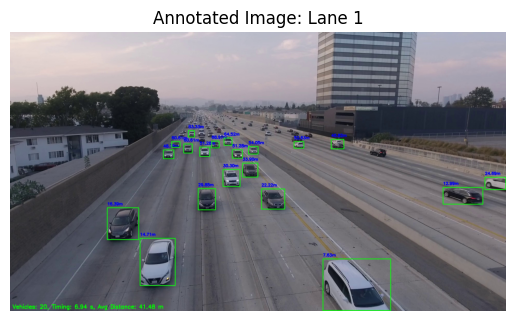

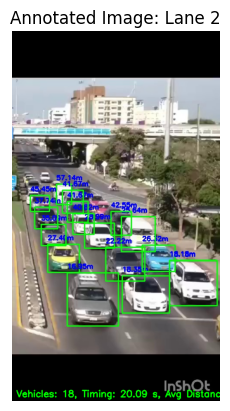

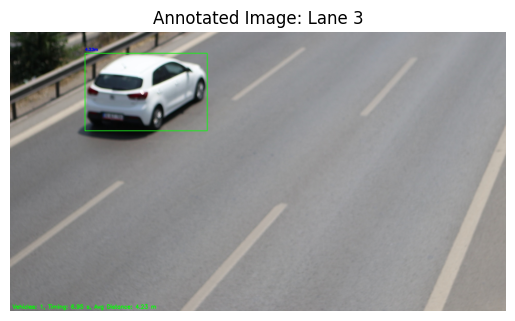

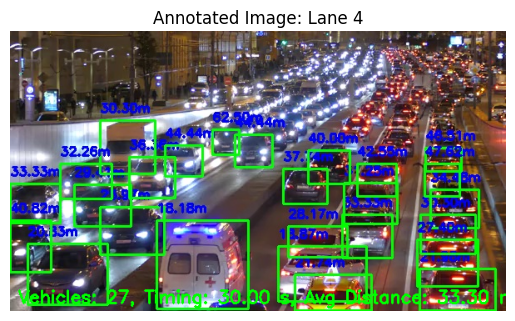

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model = YOLO('yolov8m.pt')

# Function to calculate traffic density, number of vehicles, and save annotated frame
def calculate_and_save_traffic_density(video_path, output_path, focal_length, object_width):
    total_occupied_area = 0
    vehicle_count = 0
    distances = []

    # Open the video file or camera
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video stream or file: {video_path}")
        return None, 0, []

    # Read a single frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        cap.release()
        return None, 0, []

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    total_road_area = frame_width * frame_height

    # Run YOLOv8 inference on the frame
    results = model(frame)

    # Process detected objects
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()

        for box in boxes:
            x1, y1, x2, y2 = box.astype(int)
            vehicle_area = (x2 - x1) * (y2 - y1)
            total_occupied_area += vehicle_area
            vehicle_count += 1

            # Estimate the distance of the vehicle from the camera
            vehicle_pixel_width = x2 - x1
            if vehicle_pixel_width > 0:
                distance = (focal_length * object_width) / vehicle_pixel_width
                distances.append(distance)
            else:
                distances.append(0)

            # Draw bounding boxes and distance on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{distance:.2f}m", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Save the annotated frame
    cv2.imwrite(output_path, frame)

    # Release video capture object
    cap.release()

    # Calculate traffic density
    traffic_density = total_occupied_area / total_road_area
    return traffic_density, vehicle_count, distances

# Paths to the video files and output paths for the four lanes
video_paths = ['/content/demo1.mp4', '/content/demo.mp4', '/content/demo3.mov', '/content/demo2.mp4']
output_paths = ['/content/annotated_lane1.jpg', '/content/annotated_lane2.jpg', '/content/annotated_lane3.jpg', '/content/annotated_lane4.jpg']

# Define the focal length and object width for distance calculation
focal_length = 1000
object_width = 2

# Calculate traffic densities, vehicle counts, distances, and save annotated frames for each lane
traffic_densities = []
vehicle_counts = []
distances_list = []

for video_path, output_path in zip(video_paths, output_paths):
    density, count, distances = calculate_and_save_traffic_density(video_path, output_path, focal_length, object_width)
    if density is not None:
        traffic_densities.append(density)
        vehicle_counts.append(count)
        distances_list.append(distances)
    else:
        traffic_densities.append(0)
        vehicle_counts.append(0)
        distances_list.append([])

# Define fuzzy variables
traffic_density_var = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'traffic_density')
signal_timing_adjustment = ctrl.Consequent(np.arange(0, 61, 1), 'signal_timing_adjustment')

# Define fuzzy membership functions
traffic_density_var['low'] = fuzz.trimf(traffic_density_var.universe, [0, 0, 0.3])
traffic_density_var['medium'] = fuzz.trimf(traffic_density_var.universe, [0.2, 0.5, 0.8])
traffic_density_var['high'] = fuzz.trimf(traffic_density_var.universe, [0.7, 1.0, 1.0])

signal_timing_adjustment['short'] = fuzz.trimf(signal_timing_adjustment.universe, [0, 0, 20])
signal_timing_adjustment['medium'] = fuzz.trimf(signal_timing_adjustment.universe, [15, 30, 45])
signal_timing_adjustment['long'] = fuzz.trimf(signal_timing_adjustment.universe, [40, 60, 60])

# Define fuzzy rules
rule1 = ctrl.Rule(traffic_density_var['high'], signal_timing_adjustment['long'])
rule2 = ctrl.Rule(traffic_density_var['medium'], signal_timing_adjustment['medium'])
rule3 = ctrl.Rule(traffic_density_var['low'], signal_timing_adjustment['short'])

# Create a control system and simulation
signal_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
signal_sim = ctrl.ControlSystemSimulation(signal_ctrl)

# Calculate signal timing adjustments for each lane
signal_timings = []
for density in traffic_densities:
    signal_sim.input['traffic_density'] = density
    signal_sim.compute()
    signal_timing = signal_sim.output['signal_timing_adjustment']
    signal_timings.append(signal_timing)

# Determine lane priorities based on traffic density
lane_priorities = sorted(enumerate(traffic_densities), key=lambda x: x[1], reverse=True)
# Extract the lanes and their densities
sorted_lanes = [lane for lane, _ in lane_priorities]
sorted_densities = [density for _, density in lane_priorities]
sorted_timings = [signal_timings[lane] for lane in sorted_lanes]

# Plot traffic densities
plt.figure(figsize=(12, 6))
plt.bar(range(1, 5), sorted_densities, tick_label=[f'Lane {i+1}' for i in sorted_lanes], color='skyblue')
plt.xlabel('Lane')
plt.ylabel('Traffic Density')
plt.title('Traffic Density by Lane')
plt.show()

# Plot signal timing adjustments
plt.figure(figsize=(12, 6))
plt.bar(range(1, 5), sorted_timings, tick_label=[f'Lane {i+1}' for i in sorted_lanes], color='lightgreen')
plt.xlabel('Lane')
plt.ylabel('Signal Timing Adjustment (seconds)')
plt.title('Signal Timing Adjustments by Lane')
plt.show()

# Print the signal timing adjustments for all lanes
for i, (timing, count, distances) in enumerate(zip(signal_timings, vehicle_counts, distances_list), start=1):
    avg_distance = np.mean(distances) if distances else 0
    print(f"Lane {i} - Vehicles: {count}, Avg Distance: {avg_distance:.2f} meters, Signal Timing Adjustment: {timing:.2f} seconds")

# Display saved annotated images with vehicle count, timing, and distance
for i, (output_path, count, timing, distances) in enumerate(zip(output_paths, vehicle_counts, signal_timings, distances_list), start=1):
    img = cv2.imread(output_path)
    if img is not None:
        avg_distance = np.mean(distances) if distances else 0
        text = f"Vehicles: {count}, Timing: {timing:.2f} s, Avg Distance: {avg_distance:.2f} m"
        cv2.putText(img, text, (10, img.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        plt.figure()
        plt.title(f"Annotated Image: Lane {i}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    else:
        print(f"Error loading image: {output_path}")

plt.show()


Lane 1 - FASTag Count: 66, Signal Timing Adjustment: 45.00 seconds, Signal: green
Lane 2 - FASTag Count: 20, Signal Timing Adjustment: 21.33 seconds, Signal: green
Lane 3 - FASTag Count: 21, Signal Timing Adjustment: 27.46 seconds, Signal: green
Lane 4 - FASTag Count: 76, Signal Timing Adjustment: 53.00 seconds, Signal: green


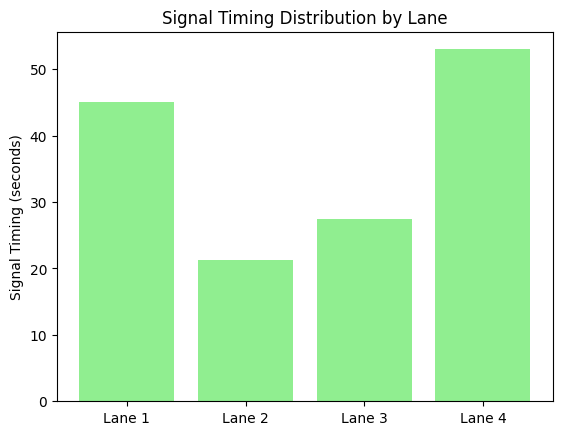

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Function to simulate FASTag count retrieval for each lane
def get_fastag_count(lane_id):
    # Placeholder function - Replace with actual FASTag data retrieval
    return np.random.randint(0, 101)

# Paths to the video files and output paths for the four lanes
lane_ids = [1, 2, 3, 4]

# Calculate traffic densities and FASTag counts for each lane
traffic_densities = []
fastag_counts = []

for lane_id in lane_ids:
    fastag_count = get_fastag_count(lane_id)
    # Assuming density is directly proportional to FASTag count for simplicity
    density = fastag_count / 100.0
    traffic_densities.append(density)
    fastag_counts.append(fastag_count)

# Define fuzzy variables
traffic_density_var = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'traffic_density')
traffic_severity_var = ctrl.Antecedent(np.arange(0, 11, 1), 'traffic_severity')
signal_timing_adjustment = ctrl.Consequent(np.arange(15, 76, 1), 'signal_timing_adjustment')

# Define fuzzy membership functions
traffic_density_var['low'] = fuzz.trimf(traffic_density_var.universe, [0, 0, 0.3])
traffic_density_var['medium'] = fuzz.trimf(traffic_density_var.universe, [0.2, 0.5, 0.8])
traffic_density_var['high'] = fuzz.trimf(traffic_density_var.universe, [0.7, 1.0, 1.0])

traffic_severity_var['low'] = fuzz.trimf(traffic_severity_var.universe, [0, 0, 3])
traffic_severity_var['medium'] = fuzz.trimf(traffic_severity_var.universe, [2, 5, 8])
traffic_severity_var['high'] = fuzz.trimf(traffic_severity_var.universe, [7, 10, 10])

signal_timing_adjustment['short'] = fuzz.trimf(signal_timing_adjustment.universe, [15, 15, 30])
signal_timing_adjustment['medium'] = fuzz.trimf(signal_timing_adjustment.universe, [25, 45, 65])
signal_timing_adjustment['long'] = fuzz.trimf(signal_timing_adjustment.universe, [55, 75, 75])

# Define fuzzy rules using both density and severity
rule1 = ctrl.Rule(traffic_density_var['high'] & traffic_severity_var['high'], signal_timing_adjustment['long'])
rule2 = ctrl.Rule(traffic_density_var['medium'] & traffic_severity_var['medium'], signal_timing_adjustment['medium'])
rule3 = ctrl.Rule(traffic_density_var['low'] & traffic_severity_var['low'], signal_timing_adjustment['short'])
rule4 = ctrl.Rule(traffic_density_var['high'], signal_timing_adjustment['long'])  # Prioritize high density
rule5 = ctrl.Rule(traffic_severity_var['high'], signal_timing_adjustment['long'])  # Prioritize high severity

# Create a control system and simulation
signal_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
signal_sim = ctrl.ControlSystemSimulation(signal_ctrl)

# Calculate signal timing adjustments for each lane
signal_timings = []
for density, fastag_count in zip(traffic_densities, fastag_counts):
    severity = fastag_count / 10  # Simplified severity calculation
    signal_sim.input['traffic_density'] = density
    signal_sim.input['traffic_severity'] = severity
    signal_sim.compute()
    signal_timing = signal_sim.output['signal_timing_adjustment']
    signal_timings.append(signal_timing)

# Set all signals to green
signals = ['green'] * len(lane_ids)

# Print the signal timing adjustments and signal status for all lanes
for i, (timing, count, signal) in enumerate(zip(signal_timings, fastag_counts, signals), start=1):
    print(f"Lane {i} - FASTag Count: {count}, Signal Timing Adjustment: {timing:.2f} seconds, Signal: {signal}")

# Optionally, visualize the signal distribution with all bars in a lighter green color
plt.bar([f'Lane {i+1}' for i in range(len(lane_ids))], signal_timings, color='#90EE90')  # Light green color
plt.ylabel('Signal Timing (seconds)')
plt.title('Signal Timing Distribution by Lane')
plt.show()

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Function to simulate FASTag count retrieval for each lane (1 or 2 for emergency vehicles)
def get_fastag_count(lane_id):
    # Simulate emergency vehicle counts (either 1 or 2)
    return np.random.choice([1, 2])

# Paths to the video files and output paths for the four lanes
lane_ids = [1, 2, 3, 4]

# Calculate traffic densities and FASTag counts for each lane
traffic_densities = []
fastag_counts = []

for lane_id in lane_ids:
    fastag_count = get_fastag_count(lane_id)
    # Assuming density is directly proportional to FASTag count for simplicity
    density = fastag_count / 2.0  # Max count is 2, so density ranges from 0 to 1
    traffic_densities.append(density)
    fastag_counts.append(fastag_count)

# Define fuzzy variables
traffic_density_var = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'traffic_density')
traffic_severity_var = ctrl.Antecedent(np.arange(0, 11, 1), 'traffic_severity')
signal_timing_adjustment = ctrl.Consequent(np.arange(15, 76, 1), 'signal_timing_adjustment')

# Define fuzzy membership functions
traffic_density_var['low'] = fuzz.trimf(traffic_density_var.universe, [0, 0, 0.3])
traffic_density_var['medium'] = fuzz.trimf(traffic_density_var.universe, [0.2, 0.5, 0.8])
traffic_density_var['high'] = fuzz.trimf(traffic_density_var.universe, [0.7, 1.0, 1.0])

traffic_severity_var['low'] = fuzz.trimf(traffic_severity_var.universe, [0, 0, 3])
traffic_severity_var['medium'] = fuzz.trimf(traffic_severity_var.universe, [2, 5, 8])
traffic_severity_var['high'] = fuzz.trimf(traffic_severity_var.universe, [7, 10, 10])

signal_timing_adjustment['short'] = fuzz.trimf(signal_timing_adjustment.universe, [15, 15, 30])
signal_timing_adjustment['medium'] = fuzz.trimf(signal_timing_adjustment.universe, [25, 45, 65])
signal_timing_adjustment['long'] = fuzz.trimf(signal_timing_adjustment.universe, [55, 75, 75])

# Define fuzzy rules using both density and severity
rule1 = ctrl.Rule(traffic_density_var['high'] & traffic_severity_var['high'], signal_timing_adjustment['long'])
rule2 = ctrl.Rule(traffic_density_var['medium'] & traffic_severity_var['medium'], signal_timing_adjustment['medium'])
rule3 = ctrl.Rule(traffic_density_var['low'] & traffic_severity_var['low'], signal_timing_adjustment['short'])
rule4 = ctrl.Rule(traffic_density_var['high'], signal_timing_adjustment['long'])  # Prioritize high density
rule5 = ctrl.Rule(traffic_severity_var['high'], signal_timing_adjustment['long'])  # Prioritize high severity

# Create a control system and simulation
signal_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
signal_sim = ctrl.ControlSystemSimulation(signal_ctrl)

# Calculate signal timing adjustments for each lane
signal_timings = []
for density, fastag_count in zip(traffic_densities, fastag_counts):
    severity = fastag_count * 5  # Simplified severity calculation
    signal_sim.input['traffic_density'] = density
    signal_sim.input['traffic_severity'] = severity
    signal_sim.compute()
    signal_timing = signal_sim.output['signal_timing_adjustment']
    signal_timings.append(signal_timing)

# Set all signals to green
signals = ['green'] * len(lane_ids)

# Print the signal timing adjustments and signal status for all lanes
for i, (timing, count, signal) in enumerate(zip(signal_timings, fastag_counts, signals), start=1):
    print(f"Lane {i} - Emergency Vehicle Count: {count}, Signal Timing Adjustment: {timing:.2f} seconds, Signal: {signal}")


ModuleNotFoundError: No module named 'skfuzzy'


Iteration 1
Error in computing signal timing: 'signal_green_duration'
Lane 1 - Total FASTag Count: 78, Emergency Vehicles: 1, Green Duration: 35 seconds, Signal: green
Lane 2 - Total FASTag Count: 64, Emergency Vehicles: 2, Red Duration: 40 seconds, Signal: red
Lane 3 - Total FASTag Count: 54, Emergency Vehicles: 1, Red Duration: 80 seconds, Signal: red
Lane 4 - Total FASTag Count: 101, Emergency Vehicles: 2, Red Duration: 120 seconds, Signal: red


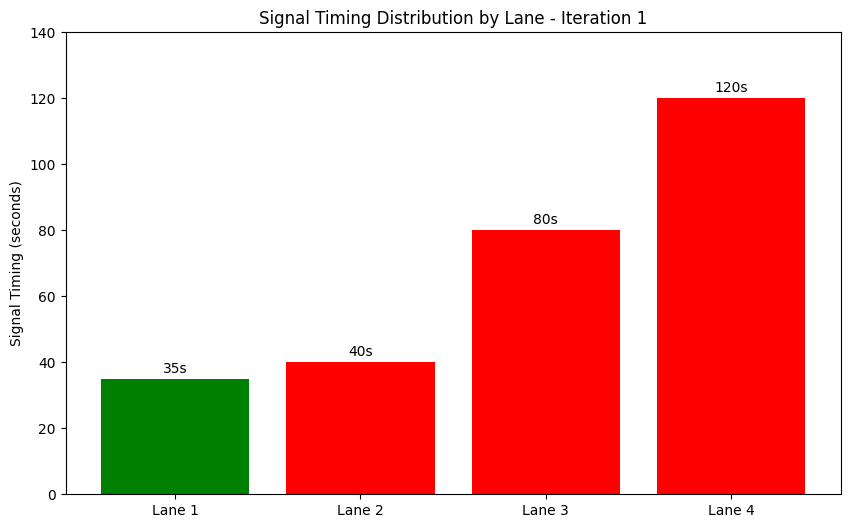


Iteration 2
Error in computing signal timing: 'signal_green_duration'
Lane 1 - Total FASTag Count: 70, Emergency Vehicles: 2, Red Duration: 105 seconds, Signal: red
Lane 2 - Total FASTag Count: 59, Emergency Vehicles: 1, Green Duration: 20 seconds, Signal: green
Lane 3 - Total FASTag Count: 78, Emergency Vehicles: 0, Red Duration: 25 seconds, Signal: red
Lane 4 - Total FASTag Count: 99, Emergency Vehicles: 2, Red Duration: 65 seconds, Signal: red


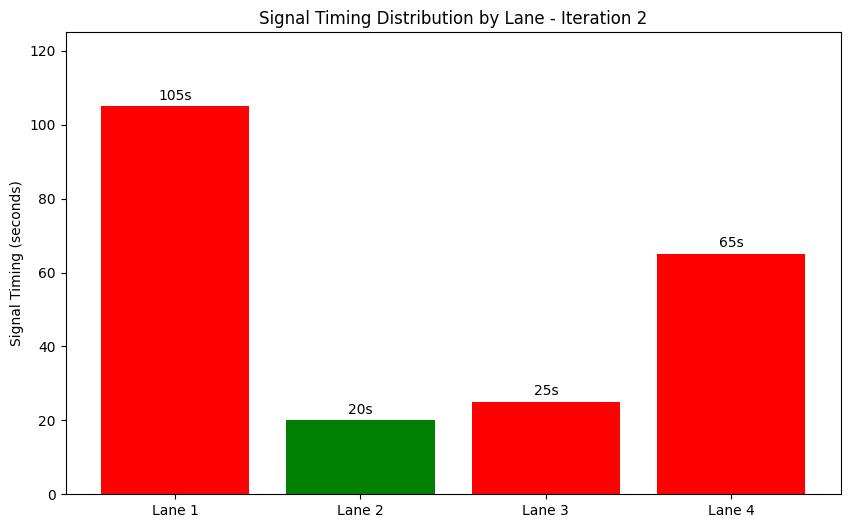


Iteration 3
Error in computing signal timing: 'signal_green_duration'
Lane 1 - Total FASTag Count: 86, Emergency Vehicles: 1, Red Duration: 80 seconds, Signal: red
Lane 2 - Total FASTag Count: 32, Emergency Vehicles: 0, Red Duration: 120 seconds, Signal: red
Lane 3 - Total FASTag Count: 88, Emergency Vehicles: 0, Green Duration: 35 seconds, Signal: green
Lane 4 - Total FASTag Count: 82, Emergency Vehicles: 2, Red Duration: 40 seconds, Signal: red


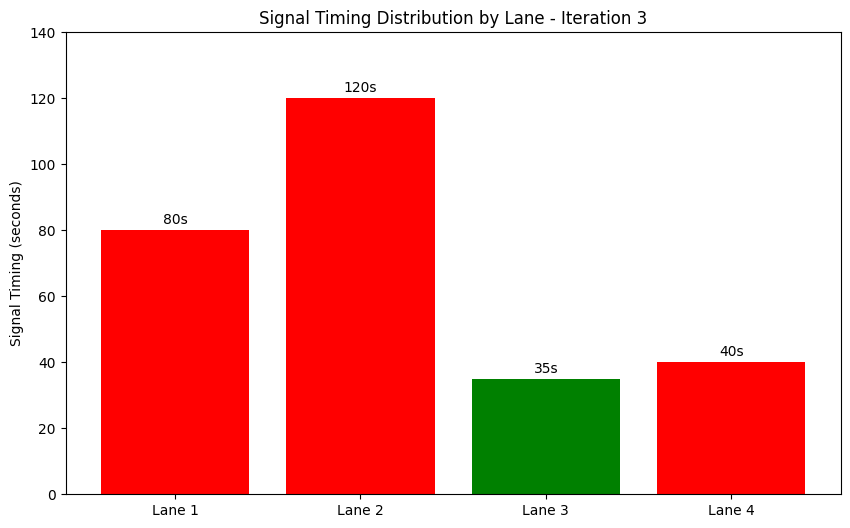


Iteration 4
Lane 1 - Total FASTag Count: 65, Emergency Vehicles: 2, Red Duration: 40 seconds, Signal: red
Lane 2 - Total FASTag Count: 54, Emergency Vehicles: 1, Red Duration: 80 seconds, Signal: red
Lane 3 - Total FASTag Count: 99, Emergency Vehicles: 0, Red Duration: 120 seconds, Signal: red
Lane 4 - Total FASTag Count: 93, Emergency Vehicles: 2, Green Duration: 35 seconds, Signal: green


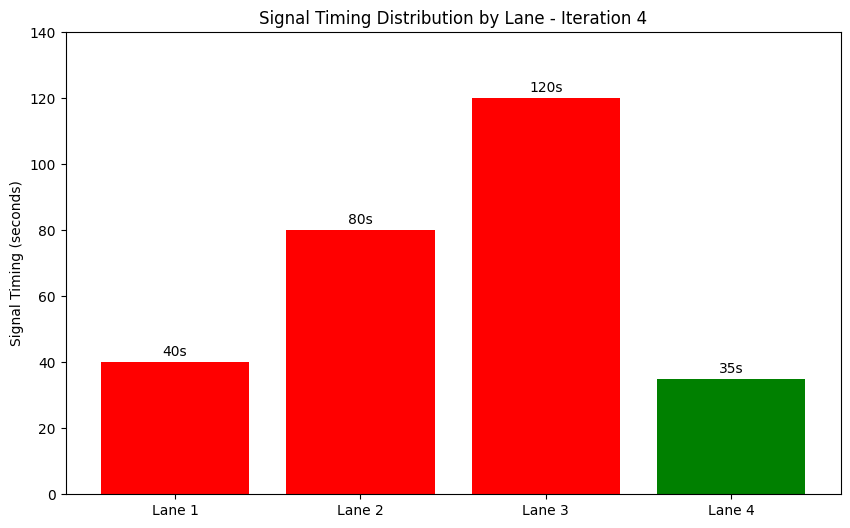

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Function to simulate FASTag count retrieval for each lane
def get_fastag_count(lane_id):
    normal_vehicle_count = np.random.randint(30, 101)
    emergency_vehicle_count = np.random.randint(0, 3)  # Emergency vehicles between 0 and 2
    return normal_vehicle_count, emergency_vehicle_count

# Define fuzzy variables
traffic_density_var = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'traffic_density')
traffic_severity_var = ctrl.Antecedent(np.arange(0, 11, 1), 'traffic_severity')
signal_green_duration = ctrl.Consequent(np.arange(10, 61, 1), 'signal_green_duration')

# Define fuzzy membership functions for traffic density
traffic_density_var['low'] = fuzz.trimf(traffic_density_var.universe, [0, 0, 0.3])
traffic_density_var['medium'] = fuzz.trimf(traffic_density_var.universe, [0.2, 0.5, 0.8])
traffic_density_var['high'] = fuzz.trimf(traffic_density_var.universe, [0.7, 1.0, 1.0])

# Define fuzzy membership functions for traffic severity
traffic_severity_var['low'] = fuzz.trimf(traffic_severity_var.universe, [0, 0, 3])
traffic_severity_var['medium'] = fuzz.trimf(traffic_severity_var.universe, [2, 5, 8])
traffic_severity_var['high'] = fuzz.trimf(traffic_severity_var.universe, [7, 10, 10])

# Define fuzzy membership functions for signal green duration
signal_green_duration['short'] = fuzz.trimf(signal_green_duration.universe, [10, 10, 25])
signal_green_duration['medium'] = fuzz.trimf(signal_green_duration.universe, [20, 30, 40])
signal_green_duration['long'] = fuzz.trimf(signal_green_duration.universe, [35, 50, 60])

# Define fuzzy rules
rule1 = ctrl.Rule(traffic_density_var['high'] & traffic_severity_var['high'], signal_green_duration['long'])
rule2 = ctrl.Rule(traffic_density_var['high'] & traffic_severity_var['medium'], signal_green_duration['long'])
rule3 = ctrl.Rule(traffic_density_var['medium'] & traffic_severity_var['high'], signal_green_duration['medium'])
rule4 = ctrl.Rule(traffic_density_var['medium'] & traffic_severity_var['medium'], signal_green_duration['medium'])
rule5 = ctrl.Rule(traffic_density_var['low'] & traffic_severity_var['low'], signal_green_duration['short'])
rule6 = ctrl.Rule(traffic_density_var['low'] & traffic_severity_var['high'], signal_green_duration['medium'])
rule7 = ctrl.Rule(traffic_density_var['high'], signal_green_duration['long'])  # Prioritize high density
rule8 = ctrl.Rule(traffic_severity_var['high'], signal_green_duration['long'])  # Prioritize high severity

# Create control system and simulation
signal_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
signal_sim = ctrl.ControlSystemSimulation(signal_ctrl)

# Constants
x = 5
y = 40

# Function to calculate signal timings and assign signals
def calculate_signals(lane_ids):
    """
    Calculates green light durations for each lane based on traffic data.
    Returns a tuple of (signal_timings, fastag_counts, traffic_severities).
    """
    traffic_densities = []
    traffic_severities = []
    fastag_counts = []

    for lane_id in lane_ids:
        normal_count, emergency_count = get_fastag_count(lane_id)
        total_count = normal_count + emergency_count

        # Update traffic density based on total FASTag vehicle count
        density = total_count / 100.0  # Normalize density between 0 and 1
        severity = emergency_count
        traffic_densities.append(density)
        traffic_severities.append(severity)
        fastag_counts.append(total_count)

    signal_timings = []
    for density, severity in zip(traffic_densities, traffic_severities):
        signal_sim.input['traffic_density'] = density
        signal_sim.input['traffic_severity'] = severity

        try:
            signal_sim.compute()
            green_duration = signal_sim.output['signal_green_duration']
            # Constrain green signal duration between 10 and 35 seconds
            green_duration = np.clip(green_duration, 10, 35)
            signal_timings.append(green_duration)
        except Exception as e:
            print(f"Error in computing signal timing: {e}")
            signal_timings.append(20)  # Default green duration

    return signal_timings, fastag_counts, traffic_severities


# Lane IDs
lane_ids = [1, 2, 3, 4]

# Store previous green signal timings for each lane (for red duration calculation)
previous_green_signals = [20] * len(lane_ids)  # Initialize with default green duration

# Simulation for 4 iterations
for loop in range(4):
    print(f"\nIteration {loop + 1}")

    # Calculate signal timings
    signal_timings, fastag_counts, traffic_severities = calculate_signals(lane_ids)

    if loop == 0:
        # First iteration: Start with Lane 1
        green_timing_lane1 = int(signal_timings[0])
        red_timing_lane2 = green_timing_lane1 + x
        red_timing_lane3 = red_timing_lane2 + y
        red_timing_lane4 = red_timing_lane3 + y
        signal_timing_results = [green_timing_lane1, red_timing_lane2, red_timing_lane3, red_timing_lane4]
    elif loop == 1:
        # Second iteration: Start with Lane 2
        green_timing_lane2 = int(signal_timings[1])
        red_timing_lane3 = green_timing_lane2 + x
        red_timing_lane4 = red_timing_lane3 + y
        red_timing_lane1 = red_timing_lane4 + y
        signal_timing_results = [red_timing_lane1, green_timing_lane2, red_timing_lane3, red_timing_lane4]
    elif loop == 2:
        # Third iteration: Start with Lane 3
        green_timing_lane3 = int(signal_timings[2])
        red_timing_lane4 = green_timing_lane3 + x
        red_timing_lane1 = red_timing_lane4 + y
        red_timing_lane2 = red_timing_lane1 + y
        signal_timing_results = [red_timing_lane1, red_timing_lane2, green_timing_lane3, red_timing_lane4]
    elif loop == 3:
        # Fourth iteration: Start with Lane 4
        green_timing_lane4 = int(signal_timings[3])
        red_timing_lane1 = green_timing_lane4 + x
        red_timing_lane2 = red_timing_lane1 + y
        red_timing_lane3 = red_timing_lane2 + y
        signal_timing_results = [red_timing_lane1, red_timing_lane2, red_timing_lane3, green_timing_lane4]

    # Print the signal timing adjustments and signal status for all lanes
    for i, (timing, total_count, severity) in enumerate(zip(signal_timing_results, fastag_counts, traffic_severities), start=1):
        if (loop == 0 and i == 1) or (loop == 1 and i == 2) or (loop == 2 and i == 3) or (loop == 3 and i == 4):
            signal = 'green'
        else:
            signal = 'red'

        if signal == 'green':
            print(f"Lane {i} - Total FASTag Count: {total_count}, Emergency Vehicles: {severity}, Green Duration: {timing} seconds, Signal: {signal}")
        else:
            print(f"Lane {i} - Total FASTag Count: {total_count}, Emergency Vehicles: {severity}, Red Duration: {timing} seconds, Signal: {signal}")

    # Visualization: Bar chart of signal timings
    lane_labels = [f'Lane {i}' for i in range(1, len(lane_ids) + 1)]
    colors_chart = ['green' if lane_labels[i] == f'Lane {loop + 1}' else 'red' for i in range(len(lane_ids))]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(lane_labels, signal_timing_results, color=colors_chart)
    plt.ylabel('Signal Timing (seconds)')
    plt.title(f'Signal Timing Distribution by Lane - Iteration {loop + 1}')

    # Annotate bars with timing values
    for bar, timing in zip(bars, signal_timing_results):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f'{timing}s', ha='center', va='bottom')

    plt.ylim(0, max(signal_timing_results) + 20)
    plt.show()